In [23]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os

ROOT = "."
SIM = 0 # choose
FIGURES_FOLDER = ROOT + f"/Figures/sim{SIM}/"
SIM_FOLDER = ROOT + f"/Simulations/sim{SIM}/"

if not os.path.exists(FIGURES_FOLDER):
    os.mkdir(FIGURES_FOLDER)
if not os.path.exists(SIM_FOLDER):
    os.mkdir(SIM_FOLDER)

In [2]:
def G(rho, p, P):
  return p*(1-rho/P)

# 1D parameter derivation:
# delta^2 / (1*tau) -> D for delta, tau -> 0
# Du = theta_u * D
# Di = theta_i * D

delta = 0.05 # mm
tau = 0.02 # h
D = delta**2/(2*tau)
Du = Di = 1.5e-3 # mm^2/h
theta_u = Du/D
theta_i = Di/D
beta = 1.02e-1 # h-1
p = 1.87e-2 # h-1
q = 4.17e-2 # h-1
P = K = 1e3 # 1/mm^2
c_max = int(K*delta)
Ru = 2.6 # mm
Ri = 1 # mm
# Ri = Ru
pop_unit = 1

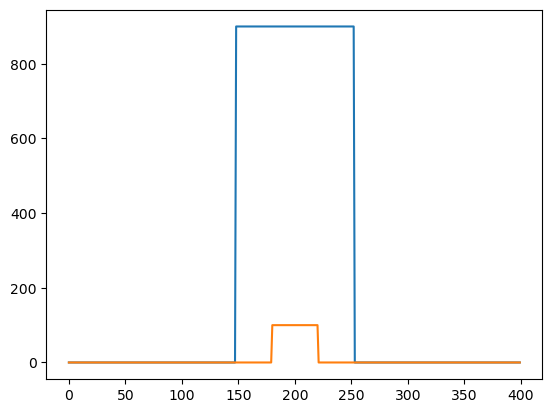

In [3]:
# def RaisedCosine(f, T, be, peak):
#   abs_f = np.abs(f)
#   if abs_f <= (1-be)/(2*T):
#     return peak
#   elif (1-be)/(2*T) < abs_f and abs_f <= (1 + be) / (2 * T):
#     return 0.5*(1 + math.cos(math.pi*T/be * ((abs_f - (1 - be)/(2*T)))))*peak
#   else:
#     return 0

def initialize_mesh(delta, Ru, Ri, c_max):
  initial_u = int(.9*K)
  initial_i = int(.1*K)
  size = int(1/delta * 10 * 2)
  domain = np.zeros((2, size))
  for i in range(size):
    if abs((i-size/2)*delta) <= Ru:
      domain[0][i] = initial_u
    if abs((i-size/2)*delta) <= Ri:
      domain[1][i] = initial_i
  # for i in range(size):
  #   domain[0][i] = RaisedCosine((i-size/2)*delta, 1/(2*Ru), 0.1*Ru, initial_u)
  # for i in range(size):
  #   domain[1][i] = RaisedCosine((i-size/2)*delta, 1/(2*Ri), 0.1*Ri, initial_i)
  return domain

domain = initialize_mesh(delta, Ru, Ri, c_max)
plt.plot(domain[0])
plt.plot(domain[1])
plt.show()

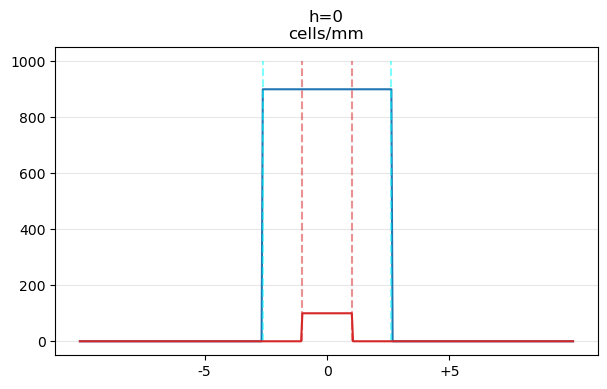

In [27]:
# define functions and parameters to save and plot results
size = int(1/delta * 10 * 2)
ticks = [size//2 - 5//delta, size//2, size//2 + 5//delta]

def plot_domain(domain, h):
  radius_u = (Ru + h*np.sqrt(Du*p/2))/delta
  radius_i = (Ri)/delta
  fig, ax = plt.subplots(figsize=(7, 4))

  # plot U
  plt.plot(domain[0], color="tab:blue")
  ax.set_xticks(ticks)
  ax.set_xticklabels(["-5","0","+5"],rotation=0)
  ax.title.set_text(f"h={h}\ncells/mm")
  plt.vlines([size//2 + radius_u, size//2 - radius_u], 0, c_max/delta, colors=["cyan"], linestyles="dashed", alpha=0.5)
  # plot I
  plt.plot(domain[1], color="tab:red")
  plt.vlines([size//2 - radius_i, size//2 + radius_i], 0, c_max/delta, colors=["tab:red"], linestyles="dashed", alpha=0.5)
  ax.yaxis.grid(alpha=0.3)
  # save and plot figure
  plt.savefig(f"{FIGURES_FOLDER}/pde_pressure_walk_h{h}.svg", format='svg', dpi=200)
  plt.show()


plot_domain(domain, 0)

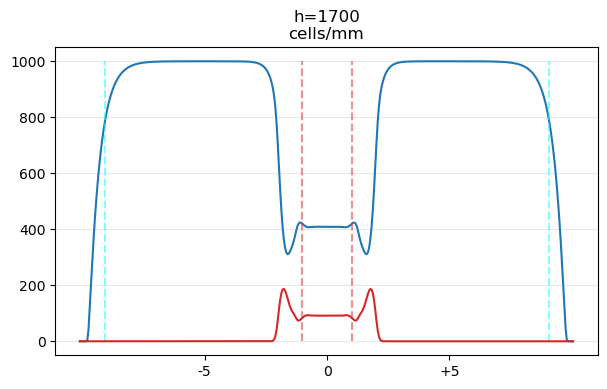

In [31]:
def upwind_morselli(T, domain=domain, dx = delta, dt = tau):

  nt = int(T/dt)
  ns = int(20/dx) # domain of 20mm
  u = np.zeros((nt+1, ns))
  i = np.zeros((nt+1, ns))
  u[0] = domain[0].copy()
  i[0] = domain[1].copy()


  for t in range(nt):

    p_grad = (u[t, 1:]-u[t, :-1] + i[t, 1:]-i[t, :-1])/dx

    flux_u = (Du/K)*(-np.maximum(-p_grad,0)*u[t, :-1]+np.maximum(p_grad,0)*u[t, 1:])
    flux_i = (Di/K)*(-np.maximum(-p_grad,0)*i[t, :-1]+np.maximum(p_grad,0)*i[t, 1:])

    flux_u = np.hstack([0, flux_u, 0]) # Neumann BC
    flux_i = np.hstack([0, flux_i, 0]) # Neumann BC

    u[t+1] = u[t] + (dt/dx)*(flux_u[1:]-flux_u[:-1]) + (dt)*(p*u[t]*(1-(u[t] + i[t])/K) - (beta/K)*u[t]*i[t])
    i[t+1] = i[t] + (dt/dx)*(flux_i[1:]-flux_i[:-1]) + (dt)*((beta/K)*u[t]*i[t] - q*i[t])
  return u, i

T = 1700
u, i = upwind_morselli(T=T, domain=domain, dx=delta, dt=tau)

# plot last time step
plot_domain([u[-1],i[-1]], T)

In [33]:
# save numpy array of results
for t in range(int(T/tau)+1):
  if t%int(10/tau)==0:
    h = int(t*tau)
    # plot_domain([u[t], i[t]], h)
    result = np.array([u[t], i[t]])
    np.save(f"{SIM_FOLDER}/pde_pressure_1d_h{h}.npy", result.data)